## Modelando una Figura Compleja

Pasos:
  - Descargar la Figura Compleja de Rey original y un ejemplo
  - Descomponer la ROCF en polígonos para luego generar nuevos casos
  - Probar algunas utilidades para descomponer ejemplos dibujados
  - Generar un dataset mediante un Pipeline de Data Augmentation
  - Aplicar aprendizaje no supervisado a nuestro dataset, en particular Autoencoders
  - Explorar el espacio latente generado
  - Bonus: probar con casos reales, comparar con otras técnicas (ej. PCA)


### Imports y funciones de utilidad

In [1]:
from IPython.display import clear_output, HTML
import numpy as np
from time import sleep
from matplotlib import animation
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
from skimage.measure import find_contours, approximate_polygon
from skimage.transform import probabilistic_hough_line, resize
from skimage.filters import sobel, scharr, threshold_otsu, gaussian
from skimage.exposure import equalize_adapthist, rescale_intensity
from skimage.draw import polygon_perimeter
from skimage.io import imread
from skimage.color import grey2rgb

In [3]:
import tensorflow

In [4]:
def make_fig(size=(8,6), xlim=(0,830), ylim=(670,0)):
    fig, ax = plt.subplots(figsize=(size))
    fig.tight_layout(pad=0)
    plt.xlim(xlim)
    plt.ylim(ylim,)
    plt.axis('off')
    plt.margins(False)
    return fig, ax

In [5]:
def plot_shapes(contours, n=4, linewidth=3, interval=200, palette=False):
    fig, ax = make_fig()
    frames = len(contours)
    
    if palette:
        palette = sns.color_palette('PuRd', frames + 15)[:-15]
        np.random.shuffle(palette)

    plots = []
    for i in range(n):
        plots.append(ax.plot([],[], linewidth=linewidth),)
    def init():
        return tuple([p[0] for p in plots])  
    def update(i):
        for j in range(n):
            e = np.random.choice([0,1,3,9,15])
            t = i-j-e
            if palette:
                plots[j][0].set_color(palette[t])
            plots[j][0].set_data(contours[t][:, 1], contours[t][:, 0])
            
        return tuple([p[0] for p in plots])
    
    ani = animation.FuncAnimation(fig, update, frames=frames,interval=interval, init_func=init, blit=True, )
    #ani.save("out.gif", dpi=1000, writer='imagemagick')
    plt.close()
    return HTML(ani.to_jshtml())

In [6]:
def draw_polygons(polygons, h, w, t=1):
    canv = np.zeros(shape=(h,w))
    for poly in polygons:
        rr, cc = polygon_perimeter(poly[:,0],poly[:,1], shape=(h-1,w-1))
        canv[rr,cc] = 1
        canv[rr+t,cc-t] = 1
        canv[rr-t,cc+t] = 1
        canv[rr-t,cc-t] = 1
        canv[rr+t,cc+t] = 1
    return canv

In [7]:
def remove_redundant_polys(polygons, min_dist):
    centroids = [(np.mean(p[:,0]), np.mean(p[:,1])) for p in polygons]
    to_remove = []
    for i,j in enumerate(centroids):
        for ii,jj in enumerate(centroids):
            x0, y0 = centroids[i]
            x1, y1 = centroids[ii]
            dist = np.sqrt((x1 - x0)**2 + (y1 - y0)**2)
            smallest = np.argmin([polygons[i].shape[0], polygons[ii].shape[0]])
            if dist < min_dist:
                to_remove.append([polygons[i], polygons[ii]][int(smallest)].flatten())

    return [p for p in polygons if ~np.isin(p, to_remove).any()]

In [8]:
def get_polys(img, rmv_small=True, rmv_redund=False, thresh = 50, level=0.5, min_dist=10, tol=0.5, sort=False):
    h,w = img.shape
    
    # la interpolación de matplotlib funciona excelente, pero no es recuperar 
    # la img interpolada
    #_ = plt.imshow(img, cmap='gray_r', interpolation='bilinear')
    #img = _.get_array().data
    #plt.close()
    #img = feature.canny(img, 2)

    contours = find_contours(img, level)
    polygons = []

    if rmv_small:
        contours = [c for c in contours if c.shape[0] > thresh]
    
    for c in contours:
        polygon = approximate_polygon(c, tolerance=tol)
        polygons.extend([polygon])
    
    if sort:
        polygons.sort(key=lambda x: x[0,0])
    
    l0 = len(polygons)
    if rmv_redund:
        polygons = remove_redundant_polys(polygons, min_dist=min_dist)    
    print(f'Eliminados {l0-len(polygons)} polígonos')
    
    img = draw_polygons(polygons, h, w)
    
    if sort:
        polygons.sort(key=lambda x: x[0,0])
    
    return polygons, img

### Descargamos la imagen original y un ejemplo

In [9]:
!wget -nc -O example.jpg https://upload.wikimedia.org/wikipedia/commons/thumb/f/fc/Rey-osterreith_example.jpg/800px-Rey-osterreith_example.jpg

--2019-11-07 02:55:39--  https://upload.wikimedia.org/wikipedia/commons/thumb/f/fc/Rey-osterreith_example.jpg/800px-Rey-osterreith_example.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... failed: Temporary failure in name resolution.
wget: unable to resolve host address ‘upload.wikimedia.org’


In [10]:
!wget -nc -O ROCF.png https://www.researchgate.net/publication/317224980/figure/download/fig1/AS:499777051652101@1496167542576/The-Rey-Osterrieth-Complex-Figure.png

--2019-11-07 02:55:39--  https://www.researchgate.net/publication/317224980/figure/download/fig1/AS:499777051652101@1496167542576/The-Rey-Osterrieth-Complex-Figure.png
Resolving www.researchgate.net (www.researchgate.net)... failed: Temporary failure in name resolution.
wget: unable to resolve host address ‘www.researchgate.net’


(581, 800)

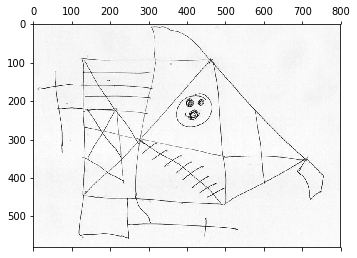

In [14]:
path_ej = r'../imgs/example.jpg'

ex_img = imread(path_ej, origin='lower')
plt.matshow(ex_img, cmap='gray')
ex_img.shape

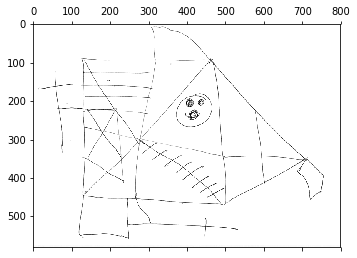

In [15]:
eq = equalize_adapthist(ex_img, clip_limit=0.0049)
plt.matshow(eq, cmap='gray')

Eliminados 0 polígonos
69


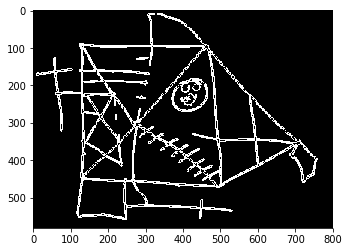

In [16]:
im = scharr(eq)
v = threshold_otsu(im)
polys, cnv = get_polys(im, level=v, rmv_small=True, rmv_redund=False, min_dist=1, thresh=30, tol=0.5)
plt.imshow(cnv, cmap='gray')
print(len(polys))

In [17]:
plot_shapes(polys, n=50, linewidth=1, interval=100)

648 837


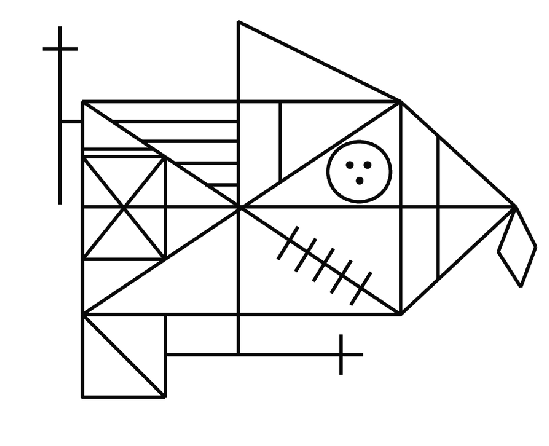

In [19]:
path_or = r'../imgs/ROCF.png'

img_ROCF = imread(path_or, as_grey=True, origin='lower')
#img_ROCF = img_ROCF[4:-4, 8:-8]
fig, ax = make_fig()
plt.imshow(img_ROCF, cmap='gray')
h_orig, w_orig = img_ROCF.shape
print (h_orig,w_orig)

In [20]:
polys, img_ = get_polys(img_ROCF, rmv_small=True, rmv_redund=False, level=0.2, thresh=0.1, tol = 0.1, min_dist=10)

Eliminados 0 polígonos


In [21]:
len(polys)

37

In [22]:
plot_shapes(polys, n=1, linewidth=1, interval=200)

In [23]:
def rey_combinations(polygons, h, w, n, priors= None, sigma = 1, downscale = 1):
    if priors == None:
        priors = [poly.shape[0]/sum(poly.shape[0] for poly in polys) for poly in polys]
    polygons = np.random.choice(polygons, replace = False, size = n, p = priors)
    img = draw_polygons(polygons, h, w)
    h,w = img.shape
    img = resize(img, (h//downscale,w//downscale))
    return gaussian(img, sigma)

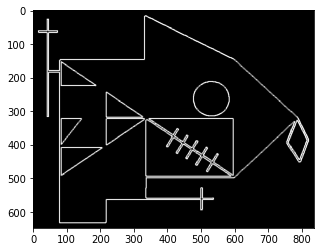

648 837


In [24]:
img = rey_combinations(polys, h_orig, w_orig, 10)
plt.imshow(img, cmap='gray')
plt.show()
h, w = img.shape
print(h,w)

## Ahora tenemos todo para generar una red

## ImgAug

In [28]:
#import cv2

from imgaug import augmenters as iaa

In [29]:
def img_gen(batch=1, flatten=False,black=False):
    
    seq = iaa.Sequential([
        iaa.GaussianBlur(sigma=(1, 2.0)),
        iaa.CropAndPad(px=100),
        #iaa.Fliplr(0.01),
        #iaa.Flipud(0.01),
        iaa.ElasticTransformation(alpha=(0, 1), sigma=(0, 0.5)),
        iaa.PiecewiseAffine(scale=(0.001, 0.005)),
        iaa.PerspectiveTransform(scale=(0.01, 0.09)),
        ])
    
    while True:
      
        x_batch = []
      
        for i in range(batch):
            if black==True:
                img = np.zeros(h*w) 
            else:    
                comb = rey_combinations(polys, h_orig, w_orig, 10, downscale=1)
                img = seq.augment_image(comb)

                img = img.reshape((h,w,1))
                if flatten: img = img.reshape(h*w)

                img = rescale_intensity(img, out_range=(0, 255))
                img /= 255
            
            x_batch.append(img)

            
        batch_x = np.array(x_batch)
        
        yield batch_x,batch_x

## Manos a la obra:

In [30]:
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Conv2D, Reshape, LeakyReLU

ModuleNotFoundError: No module named 'keras'

In [ ]:
def plot_some(model, gen, n=3):
    plt.figure(figsize=(30, 8))
    for i in range(n):
        img = next(gen)[0]
        print(img.shape)
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(img.reshape(h,w))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + n + 1)
        pred_img =  model.predict(img)  
        print(pred_img.shape)
        plt.imshow(pred_img.reshape(h, w))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.tight_layout(True)
    plt.show()

In [25]:
#h, w = h, w

inp = Input(shape=(h*w,), name = 'X')

d0 = Dense(128, activation='tanh')(inp)
d1 = Dense(128)(d0)
d1 = LeakyReLU(0.01)(d1)
z = Dense(128)(d1)
z = LeakyReLU(0.01)(z)

z_ = Dense(128)(z)
d1_ = LeakyReLU(0.01)(z_)
d1_ = Dense(128)(d1_)
d1_ = LeakyReLU(0.01)(d1_)
d0_ = Dense(128, activation = 'tanh')(d1_)

out = Dense(h*w, activation='sigmoid')(d0_)

model = Model(inp, out)
model.compile(optimizer='adam', loss='binary_crossentropy')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
X (InputLayer)               (None, 561000)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               71808128  
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
__________

(1, 660, 850, 1)
Wall time: 447 ms


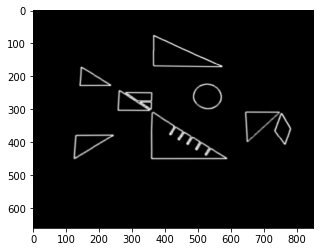

In [26]:
%%time

img = next(img_gen())
print(img[0].shape)

plt.imshow(img[0].reshape(h,w), cmap='gray')

In [27]:
#model.fit_generator(img_gen(1, flatten=True), steps_per_epoch=1, epochs=1, verbose=1,workers=-1)

In [28]:
#plot_some(model, img_gen(flatten=True,black=True), n=3)

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_train_history_loss(history):
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()


# Convolutional Autoencoder

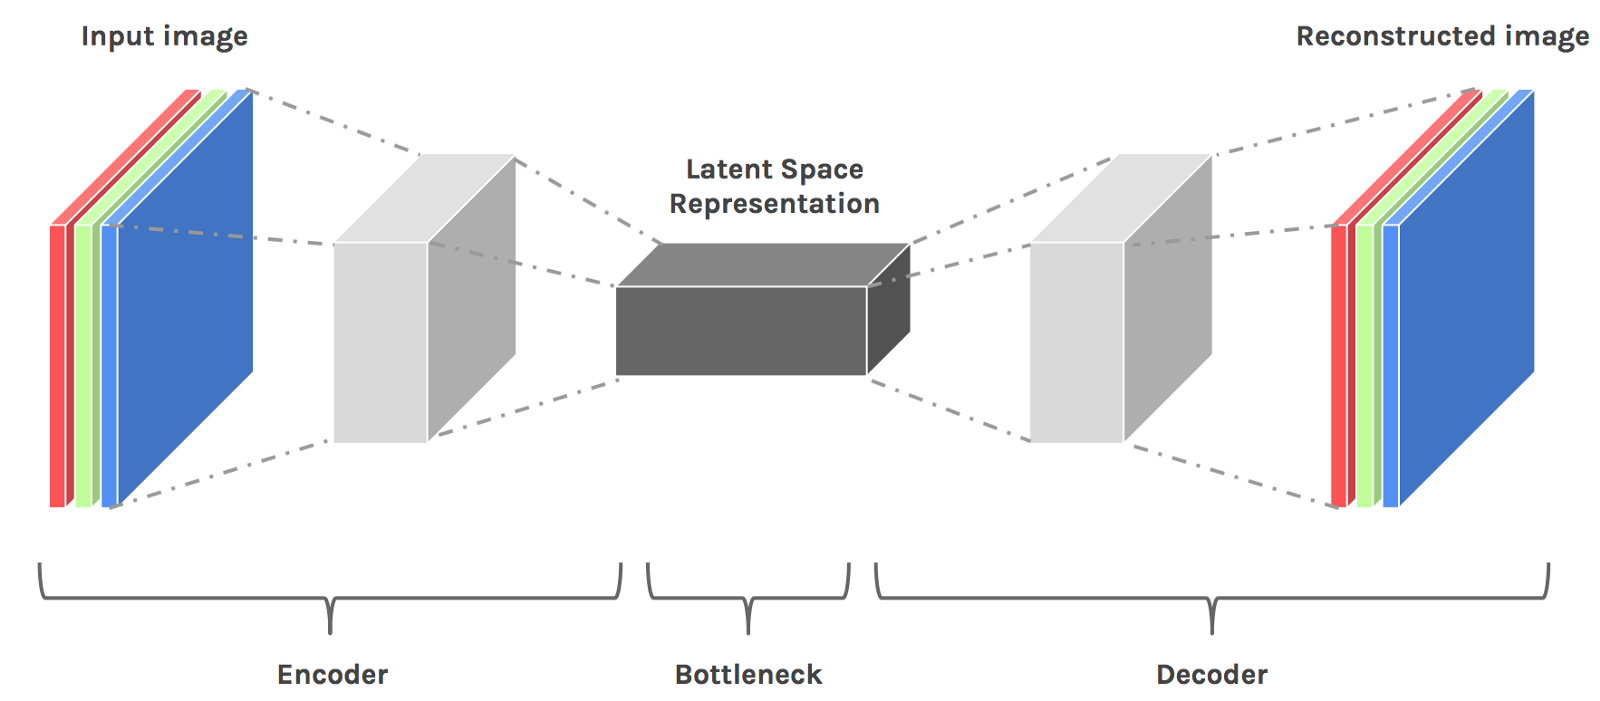

In [30]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization
from keras.models import Model
from keras import backend as K

img_rows, img_cols, img_chns = 132, 180, 1 #FA

# number of convolutional filters to use
filters = 64

# convolution kernel size
num_conv = 3

batch_size = 20
if K.image_data_format() == 'channels_first':
    original_img_size = (img_chns, img_rows, img_cols)
else:
    original_img_size = (img_rows, img_cols, img_chns)
latent_dim = 2
intermediate_dim = 128 # = 128 original FA 
epsilon_std = 1.0
epochs = 10


params = {'dim': (img_rows,img_cols),
          'batch_size': batch_size,
          'n_channels': img_chns,
          'shuffle': True
         }

print('params:',params)
print('original_img_size = ',original_img_size)



input_img = Input(shape=(img_rows, img_cols, img_chns))

x = Conv2D(32, (3, 3), activation='relu', padding='same', use_bias=False)(input_img)
x = BatchNormalization(axis=-1)(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same', use_bias=False)(x)
x = BatchNormalization(axis=-1)(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same', use_bias=False)(x)
x = BatchNormalization(axis=-1)(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(16, (3, 3), activation='relu', padding='same', use_bias=False)(encoded)
x = BatchNormalization(axis=-1)(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same', use_bias=False)(x)
x = BatchNormalization(axis=-1)(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='valid', use_bias=False)(x)
x = BatchNormalization(axis=-1)(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same', use_bias=False)(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='rmsprop', loss='binary_crossentropy')

autoencoder.summary()

params: {'dim': (132, 180), 'batch_size': 20, 'n_channels': 1, 'shuffle': True}
original_img_size =  (132, 180, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 132, 180, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 132, 180, 32)      288       
_________________________________________________________________
batch_normalization_1 (Batch (None, 132, 180, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 66, 90, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 66, 90, 16)        4608      
_________________________________________________________________
batch_normalization_2 (Batch (None, 66, 90, 16)        64        
___________________________

Instance generators

In [31]:
from my_classes_rey import DataGenerator

# Generators
training_generator = DataGenerator(path_or, 1000,  **params)
validation_generator = DataGenerator(path_or,250,  **params)
    

__Init__: Using Keras Generator of Rey Polygons images for autoencoders V.1
__Init__: Using Keras Generator of Rey Polygons images for autoencoders V.1


In [32]:
from keras.callbacks import ModelCheckpoint

fpath = "weights-ae-{epoch:02d}-{val_loss:.3f}.hdf5"
callbacks = [ModelCheckpoint(fpath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')]

#history = autoencoder.fit_generator(training_generator, 
#            epochs=epochs,
#            validation_data=validation_generator,               
#            use_multiprocessing=False,
#            verbose=1,
#            workers=6,
#            callbacks=callbacks)

#plot_train_history_loss(history)

In [33]:
# encode and decode some images from test set

def display_reconstructed(x_test, decoded_imgs, n=10):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1) 
        plt.imshow(x_test[i].reshape(img_rows, img_cols))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        if decoded_imgs is not None:
            # display reconstruction
            ax = plt.subplot(2, n, i + 1 + n)
            plt.imshow(decoded_imgs[i].reshape(img_rows, img_cols))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
    plt.show()




autoencoder.load_weights('weights-ae-10-0.001.hdf5')

#decoded_imgs = autoencoder.predict_generator(validation_generator,
#                              steps=1,
#                              max_queue_size=10,
#                              workers=6,
#                              use_multiprocessing=False,
#                              verbose=1)

#print(decoded_imgs.shape)
#display_reconstructed(decoded_imgs, decoded_imgs, 4)

In [34]:
#plot_some(model, (validation_generator, n=3)

In [35]:
#encoder = Model(input_img, encoded)


In [36]:

#num_batches = 3

#for batchIndex in range(num_batches):
#    X,X = validation_generator.__getitem__(batchIndex)

#    num_images = X.shape[0]    
#    print(X.shape)
    
    #Xencoded = encoder.predict(X)
    
   ## print(Xencoded.shape)
    
#    Xpred = autoencoder.predict(X)
#    display_reconstructed(X, Xpred, n=3)

# Variational Autoencoder (VAE)


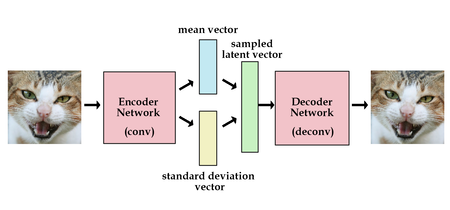


In [37]:
from scipy.stats import norm

from keras.layers import Input, Dense, Lambda, Flatten, Reshape
from keras.layers import Conv2D, Conv2DTranspose
from keras.models import Model
from keras import backend as K
from keras import metrics


In [ ]:
# input image dimensions
#img_rows, img_cols, img_chns = 28, 28, 1
#img_rows, img_cols, img_chns = h_orig, w_orig, 1 #FA
img_rows, img_cols, img_chns = 132, 176, 1 #FA

img_rows_2 = int(np.floor(img_rows/2))
img_cols_2 = int(np.floor(img_cols/2))

filters = 64
num_conv = 3
batch_size = 20
latent_dim = 2
intermediate_dim = 128 # = 128 original FA 
epsilon_std = 1.0
epochs = 10


params = {'dim': (img_rows,img_cols),
          'batch_size': batch_size,
          'n_channels': img_chns,
          'shuffle': True
         }

In [38]:
if K.image_data_format() == 'channels_first':
    original_img_size = (img_chns, img_rows, img_cols)
else:
    original_img_size = (img_rows, img_cols, img_chns)


print('params:',params)
print('original_img_size = ',original_img_size)

x = Input(shape=original_img_size)
conv_1 = Conv2D(img_chns,
                kernel_size=(2, 2),
                padding='same', activation='relu')(x)
conv_2 = Conv2D(filters,
                kernel_size=(2, 2),
                padding='same', activation='relu',
                strides=(2, 2))(conv_1)
conv_3 = Conv2D(filters,
                kernel_size=num_conv,
                padding='same', activation='relu',
                strides=1)(conv_2)
conv_4 = Conv2D(filters,
                kernel_size=num_conv,
                padding='same', activation='relu',
                strides=1)(conv_3)
flat = Flatten()(conv_4)
hidden = Dense(intermediate_dim, activation='relu')(flat)

z_mean = Dense(latent_dim)(hidden)
z_log_var = Dense(latent_dim)(hidden)


def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_var) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
# so you could write `Lambda(sampling)([z_mean, z_log_var])`
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# we instantiate these layers separately so as to reuse them later
decoder_hid = Dense(intermediate_dim, activation='relu')
decoder_upsample = Dense(filters * img_rows_2 * img_cols_2, activation='relu')

if K.image_data_format() == 'channels_first':
    output_shape = (batch_size, filters, img_rows_2, img_cols_2)
else:
    output_shape = (batch_size, img_rows_2, img_cols_2, filters)

decoder_reshape = Reshape(output_shape[1:])
decoder_deconv_1 = Conv2DTranspose(filters,
                                   kernel_size=num_conv,
                                   padding='same',
                                   strides=1,
                                   activation='relu')
decoder_deconv_2 = Conv2DTranspose(filters,
                                   kernel_size=num_conv,
                                   padding='same',
                                   strides=1,
                                   activation='relu')
if K.image_data_format() == 'channels_first':
    output_shape = (batch_size, filters, img_rows, img_cols)
else:
    output_shape = (batch_size, img_rows, img_cols, filters)
decoder_deconv_3_upsamp = Conv2DTranspose(filters,
                                          kernel_size=(3, 3),
                                          strides=(2, 2),
                                          padding='valid',
                                          activation='relu')
decoder_mean_squash = Conv2D(img_chns,
                             kernel_size=2,
                             padding='valid',
                             activation='sigmoid')

hid_decoded = decoder_hid(z)
up_decoded = decoder_upsample(hid_decoded)
reshape_decoded = decoder_reshape(up_decoded)
deconv_1_decoded = decoder_deconv_1(reshape_decoded)
deconv_2_decoded = decoder_deconv_2(deconv_1_decoded)
x_decoded_relu = decoder_deconv_3_upsamp(deconv_2_decoded)
x_decoded_mean_squash = decoder_mean_squash(x_decoded_relu)

# instantiate VAE model
vae = Model(x, x_decoded_mean_squash)

# define the loss function
xent_loss = img_rows * img_cols * metrics.binary_crossentropy(
    K.flatten(x),
    K.flatten(x_decoded_mean_squash))
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(xent_loss + kl_loss)
vae.add_loss(vae_loss)

vae.compile(optimizer='rmsprop')

vae.summary()
# load the data
#(x_train, _), (x_test, y_test) = fashion_mnist.load_data()

#x_train = x_train.astype('float32') / 255.
#x_train = x_train.reshape((x_train.shape[0],) + original_img_size)
#x_test = x_test.astype('float32') / 255.
#x_test = x_test.reshape((x_test.shape[0],) + original_img_size)

# train the VAE model
#history = vae.fit(x_train,
#        shuffle=True,
#        epochs=epochs,
#        batch_size=batch_size,
#        validation_data=(x_test, None)) #FA

# train the VAE model

params: {'dim': (132, 176), 'batch_size': 20, 'n_channels': 1, 'shuffle': True}
original_img_size =  (132, 176, 1)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 132, 176, 1)  0                                            
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 132, 176, 1)  5           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 66, 88, 64)   320         conv2d_8[0][0]                   
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 66, 88, 64)   36928       conv2d_9[0][0]              

Configure callbacks

In [39]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import CSVLogger
from keras.callbacks import EarlyStopping

def configureCallbacks():
    patience = 3
    model_filename = 'checkpoint.h5'
    csv_filename = 'Logger.CSV'
    # Early stopping for reducing over-fitting risk
    stopper = EarlyStopping(patience=patience,monitor='val_acc')

    # Model checkpoint to save the training results
    checkpointer = ModelCheckpoint(
        filepath=model_filename.format(1),
        verbose=0,
        save_best_only=True,
        save_weights_only=True)

    # CSVLogger to save the training results in a csv file
    csv_logger = CSVLogger(csv_filename.format(1), separator=';')

    callbacks = [checkpointer, csv_logger, stopper]
    
    return callbacks

Instance generators

In [40]:
del DataGenerator

In [41]:
from my_classes_rey import DataGenerator

# Generators
training_generator = DataGenerator(path_or, 1000,  **params)
validation_generator = DataGenerator(path_or,250,  **params)
    

__Init__: Using Keras Generator of Rey Polygons images for autoencoders V.1
__Init__: Using Keras Generator of Rey Polygons images for autoencoders V.1


In [ ]:
callbacks = configureCallbacks()
    
history = vae.fit_generator(training_generator, 
            epochs=epochs,
            validation_data=validation_generator,               
            use_multiprocessing=False,
            verbose=1,
            workers=6,
            callbacks=callbacks)
#fit_generator(generator, steps_per_epoch=None, epochs=1, verbose=1, callbacks=None, validation_data=None, validation_steps=None, class_weight=None, max_queue_size=10, workers=1, use_multiprocessing=False, shuffle=True, initial_epoch=0)

Epoch 1/10
18/50 [=========>....................] - ETA: 1:52 - loss: 2467.7335

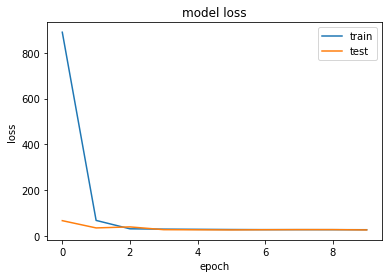

In [43]:
plot_train_history_loss(history)

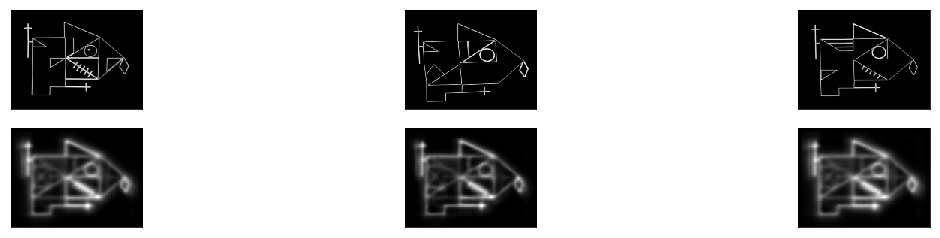

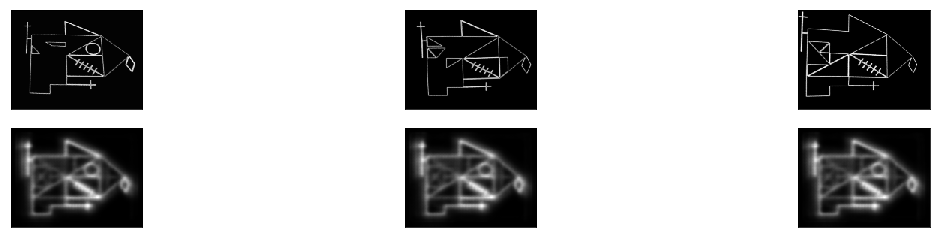

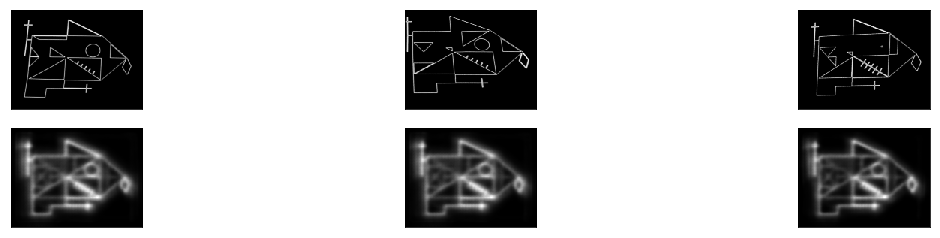

In [44]:
num_batches = 3

for batchIndex in range(num_batches):
    X,_ = validation_generator.__getitem__(batchIndex)

    num_images = X.shape[0]    
#    print(X.shape)
    
    #Xencoded = encoder.predict(X)
    
   ## print(Xencoded.shape)
    
    Xpred = vae.predict(X)
    display_reconstructed(X, Xpred, n=3)